# Klasyfikacja obrazów ze zbioru CIFAR-10 za pomocą algorytmu KNN.

Adam Brzozowski

Źródło: https://ryli.design/blog/knn

## Wczytywanie danych

In [28]:
import os
import torch
from torchvision.datasets import CIFAR10

# funckja pomocnicza tworząca tensory przechowujące zdjęcia(x) oraz ich klasy(y)
def create_tensors(dataset, range=None):
  # tensor zdjęć ze względu na sposób przechowywania danych w zbiorze CIFAR-10 musi przejść
  # permutację aby zapewnić proste korzystanie z niego w bibliotece pytorch
  # wartości pikseli zostają również podzielone przez wartość maksymalną (255) w celu normalizacji
  # danych
  x = torch.tensor(dataset.data, dtype=torch.float32).permute(0, 3, 1, 2).div_(255)
  y = torch.tensor(dataset.targets, dtype=torch.int64)
  if range is not None:
    if range <=0 or range > x.shape[0]:
      raise ValueError(
          'Nieprawidłowa wartość zmiennej range (%d). Zasięg musi mieścić się w przedziale [0, %d]'
          % (range, x.shape[0]))
    # w celu zapewnienia możliwości podpróbkowania umożliwiamy utworzenie tensoru z określonej
    # ilości rekordów
    x = x[:range].clone()
    y = y[:range].clone()
  return x, y

# funckja pobierająca dane ze zbioru CIFAR-10 i tworząca z niego odpowiednie tensory dla zbiorów
# treningowych oraz testowych
def extract_cifar10(range_train=None, range_test=None):
  is_downloaded = os.path.isdir('cifar-10-batches-py')
  dataset_train = CIFAR10(root='.', download=not is_downloaded, train=True)
  dataset_test = CIFAR10(root='.', train=False)
  x_train, y_train = create_tensors(dataset_train, range_train)
  x_test, y_test = create_tensors(dataset_test, range_test)

  return x_train, y_train, x_test, y_test

## Wizualizacja danych

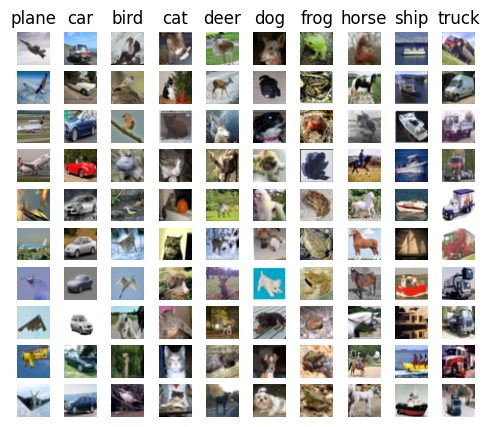

In [30]:
import matplotlib.pyplot as plt
import random

# tablica przechowująca wszystkie możliwe klasy obrazków
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# wczytanie danych do tensorów
x_train, y_train, x_test, y_test = extract_cifar10()

display_grid = []

# utworzenie kolekcji tablic przechowujących indeksy obrazków odpowiednich klas
for i, cl in enumerate(classes):
  indices = [j for j in range(len(y_test)) if y_test[j] == i]
  display_grid.append(indices)

# utworzenie tabeli i podpisanie kolumn kolejnymi klasami
fig, axs = plt.subplots(10, 10, figsize=(6, 5))
for ax, title in zip(axs[0], classes):
    ax.set_title(title)

# uzupełnienie tabeli losowymi obrazkami z odpowiednich klas
for i, ax in enumerate(axs.flat):
  row_index = random.randint(0, len(display_grid[i % 10]))
  index = display_grid[i % 10][row_index]
  img = x_test[index].permute(1, 2, 0)
  label = y_test[index]
  ax.imshow(img)
  ax.axis('off')
plt.show()

## Podpróbkowanie

In [31]:
# 500 obrazków treningowych i 250 obrazków testowych
range_train = 500
range_test = 250

x_train, y_train, x_test, y_test = extract_cifar10(range_train, range_test)

print('Kształt danych:', x_train.shape)
print('Kształt etykiet:', y_train.shape)
print('Kształt danych:', x_test.shape)
print('Kształt etykiet:', y_test.shape)

Kształt danych: torch.Size([500, 3, 32, 32])
Kształt etykiet: torch.Size([500])
Kształt danych: torch.Size([250, 3, 32, 32])
Kształt etykiet: torch.Size([250])


## Obliczanie odległości Euklidesowej
Wykorzystanie dwóch pętli for skutkujące długim czasem wykonywania

In [4]:
def compute_distances_slow(x_train, x_test):
  # określenie liczby rekordów
  num_train = x_train.shape[0]
  num_test = x_test.shape[0]

  # przygotowanie pustego tensora o kształcie(liczba_obrazów_treningowych, liczba_obrazów_testowych)
  distances = x_train.new_zeros(num_train, num_test)

  # spłaszczenie tensorów od pierwszego wymiaru, przykładowo:
  # oryginalny kształt tensora treningowego [500, 3, 32, 32]
  # kształt tensora po spłaszczeniu [500, 3072]
  train = x_train.flatten(1)
  test = x_test.flatten(1)

  for i in range(num_test):
    for j in range(num_train):
      # obliczanie odległości euklidesowej każdego obrazka testowego od każedgo obrazka treningowego
      distances[j, i] = torch.sqrt(torch.sum(torch.square(train[j] - test[i])))
  
  return distances

## Obliczanie odległości Euklidesowej
Wykorzystanie mnożenia macierzy oraz funkcjonalności Broadcast od NumPy

In [32]:
def compute_distances(x_train, x_test):
  num_train = x_train.shape[0]
  num_test = x_test.shape[0]

  distances = x_train.new_zeros(num_train, num_test)

  train = x_train.flatten(1)
  test = x_test.flatten(1)

  # podniesienie do kwadratu wszystkich elementów zbioru
  train_sq = torch.square(train)
  test_sq = torch.square(test)

  # sumowanie wierszy podniesionych do kwadratu zbiorów (wynikiem jest tablica jednowymiarowa)
  train_sum_sq = torch.sum(train_sq, 1)
  test_sum_sq = torch.sum(test_sq, 1)

  # mnożenie tensora treningowego i odwróconego tensora testowego
  # mnożenie to skutkuje tensorem o kształcie 
  # (liczba_obrazów_treningowych, liczba_obrazów_testowych)
  mul = torch.matmul(train, test.transpose(0, 1))

  # obliczenie odległości euklidesowej za pomocą rozwiniętej wersji wzoru skróconego mnożenia
  #                      x^2                         + y^2                        - 2xy
  distances = torch.sqrt(train_sum_sq.reshape(-1, 1) + test_sum_sq.reshape(1, -1) - 2*mul)

  return distances

##Klasyfikacja obrazów

In [33]:
class KnnClassifier:
  def __init__(self, x_train, y_train):
    self.x_train = x_train
    self.y_train = y_train

  # algorytm knn
  def classify(self, x_test, k=1):
    # utworzenie pustego tensora o wielkości zbioru testowego
    y_test_predictions = torch.zeros(x_test.shape[0], dtype=torch.int64)

    # dwuwymiarowa tablica distances przechowuje odległości wszystkich obrazków treningowych od
    # danego obrazka testowego
    distances = compute_distances(self.x_train, x_test)

    # iterujemy po obrazkach testowych
    for i in range(distances.shape[1]):
      # distances[:,i] = odległości wszystkich obrazków treningowych od danego obrazka testowego
      # x przechowuje indeksy k najmniejszych odległości obrazków treningowych od danego testowego
      x = torch.topk(distances[:,i], k, largest=False).indices

      # k_lowest_labels przechowuje klasy podanych k najblizszych obrazkow treningowych
      k_lowest_labels = self.y_train[x]

      # tablica y_test_predictions przechowuje wyniki predykcji dla danego obrazka testowego
      # poniższa linijka znajduje najczęściej występującą klasę tablicy k_lowest_labels
      # i przypisuje ją jako wynik
      y_test_predictions[i] = torch.argmax(torch.bincount(k_lowest_labels))

    return y_test_predictions
  
  # funkcja obliczająca dokładność predykcji algorytmu knn
  def check_accuracy(self, x_test, y_test, k=1, quiet=False):
    # y_test_predictions przechowuje listę wyników predykcji dla wszystkich obrazków testowych
    y_test_prediction = self.classify(x_test, k=k)
    num_samples = x_test.shape[0]
    # zliczanie poprawnych predykcji poprzez porównanie etykiet zbioru testowego
    # z wynikami algorytmu knn
    num_correct = (y_test == y_test_prediction).sum().item()
    accuracy = 100.0 * num_correct / num_samples
    msg = (f'Oznaczono poprawnie {num_correct} / {num_samples}. '
      f'Poprawność wynosi {accuracy:.2f}%')
    if not quiet:
      print(msg)
    return accuracy

##Wykonanie klasyfikacji dla stałej wartości paramteru k oraz ograniczonego zbioru danych

In [34]:
torch.manual_seed(0)
range_train = 5000
range_test = 500

x_train, y_train, x_test, y_test = extract_cifar10(range_train, range_test)

classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=5)

Oznaczono poprawnie 139 / 500. Poprawność wynosi 27.80%


27.8

## Kroswalidacja

In [35]:
def cross_validation(x_train, y_train, num_folds=5):
  # różne wartości k do sprawdzenia
  k_choices = [1, 2, 3, 5, 8, 10, 12, 15, 17, 20, 50, 100]

  x_train_folds = []
  y_train_folds = []

  # spłaszczona kopia zbioru treningowego
  x_train_flat = x_train.view(x_train.shape[0], -1)

  # podział zbiorów danych na podzbiory
  x_train_folds = torch.chunk(x_train_flat, num_folds, dim=0)
  y_train_folds = torch.chunk(y_train, num_folds, dim=0)

  k_accuracies = {}

  for k in k_choices:
    for folds in range(num_folds):
      # dla każdego k tworzymy daną liczbę(5) zbiorów walidacyjnych/podzbiórów testowych
      x_valid = x_train_folds[folds]
      y_valid = y_train_folds[folds]

      # dla każdego k tworzymy daną liczbę(5) podzbiórów treningowych
      # (zbiór treningowy z wyłączeniem obecnego zbioru walidacyjnego)
      x_train_k = torch.cat(x_train_folds[:folds] + x_train_folds[folds + 1:])
      y_train_k = torch.cat(y_train_folds[:folds] + y_train_folds[folds + 1:])

      knn = KnnClassifier(x_train_k, y_train_k)

      accuracy = knn.check_accuracy(x_valid, y_valid, k=k, quiet=True)

      # obliczamy dokładność predykcji algorytmu knn dla danego podzbioru i przypisujemy go
      # do odpowiedniej wartości parametru k
      k_accuracies.setdefault(k, []).append(accuracy)
    
    msg = f'Dla k równego {k}, na 5 zbiorach osiągnięto wyniki {k_accuracies[k]}'
    print(msg)

  return k_accuracies

## Najlepsza wartość parametru K

In [36]:
def get_best_k(k_accuracies):
  best_k = 0

  keys = [k for k in k_accuracies.keys()]
  values = [v for v in k_accuracies.values()]

  # znajdujemy wartość parametru k, która otrzymała najlepsze wyniki w kroswalidacji
  max_avg = torch.argmax(torch.mean(torch.tensor(values), dim=1))

  best_k = keys[max_avg]

  print(f'Najlepsza wartość paramteru k wynosi {best_k}')

  return best_k

## Wynik klasyfikacji na całym zbiorze CIFAR-10

In [37]:
torch.manual_seed(0)

x_train, y_train, x_test, y_test = extract_cifar10()

k_accuracies = cross_validation(x_train, y_train)
best_k = get_best_k(k_accuracies)

classifier = KnnClassifier(x_train, y_train)
classifier.check_accuracy(x_test, y_test, k=best_k)


Dla k równego 1, na 5 zbiorach osiągnięto wyniki [33.58, 33.61, 34.69, 33.46, 33.83]
Dla k równego 2, na 5 zbiorach osiągnięto wyniki [30.68, 30.32, 30.82, 29.96, 30.04]
Dla k równego 3, na 5 zbiorach osiągnięto wyniki [32.6, 32.62, 32.8, 32.52, 31.78]
Dla k równego 5, na 5 zbiorach osiągnięto wyniki [33.5, 32.97, 33.36, 33.4, 32.83]
Dla k równego 8, na 5 zbiorach osiągnięto wyniki [34.22, 32.83, 33.41, 33.07, 32.3]
Dla k równego 10, na 5 zbiorach osiągnięto wyniki [33.38, 32.52, 33.3, 33.32, 32.43]
Dla k równego 12, na 5 zbiorach osiągnięto wyniki [33.84, 32.36, 32.81, 32.94, 32.39]
Dla k równego 15, na 5 zbiorach osiągnięto wyniki [33.55, 32.35, 32.84, 32.73, 32.15]
Dla k równego 17, na 5 zbiorach osiągnięto wyniki [33.36, 32.28, 32.81, 33.01, 31.69]
Dla k równego 20, na 5 zbiorach osiągnięto wyniki [32.75, 32.04, 32.57, 32.48, 31.45]
Dla k równego 50, na 5 zbiorach osiągnięto wyniki [31.83, 30.89, 31.49, 31.16, 30.42]
Dla k równego 100, na 5 zbiorach osiągnięto wyniki [30.03, 29.02,

35.39